In [7]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import sys
import os

# Add the parent directory to sys.path to import from app module
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

# Import BikeTrip from app.models
from app.models import BikeTrip,BikeStation

from typing import Optional
from sqlmodel import SQLModel, Field, create_engine
import uuid
from sqlmodel import Field, Session, SQLModel, create_engine


In [10]:
one_bikes = duckdb.sql(""" 
SELECT * EXCLUDE(hora_retiro,hora_arribo), hora_retiro::TIME as hora_retiro, hora_arribo::TIME as hora_arribo
FROM read_parquet("./data/2025_01.parquet")
ORDER BY fecha_arribo_completa ASC
""").df()

In [11]:
engine = create_engine("sqlite:///C:/Users/gerym/Documents/mcp/mcp_ecobici/bike_sharing2.db")

one_bikes.to_sql("bike_trip", con=engine, if_exists="replace", index=False)

# with Session(engine) as session:
#     session.bulk_insert_mappings(BikeTrip, records)
#     session.commit()

1809709

In [87]:
# Convert DataFrame rows to BikeTrip instances
bike_trips = [BikeTrip(**row) for row in one_bike.to_dict(orient="records")]

engine = create_engine("sqlite:///C:/Users/gerym/Documents/mcp/mcp_ecobici/bike_sharing2.db")

# Insert into the database
with Session(engine) as session:
    session.add_all(bike_trips)
    session.commit()


KeyboardInterrupt: 

In [46]:
with duckdb.connect("C:/Users/gerym/Documents/mcp/mcp_ecobici/bike_sharing.db") as con:
    tables = con.execute("SHOW TABLES").fetchall()
    
    # Show column names and types for the 'bike_trips' table
    columns_info = con.execute("PRAGMA table_info('bike_trips')").fetchdf()
    print(columns_info[['name', 'type']])
    

                     name     type
0          genero_usuario  VARCHAR
1            edad_usuario   BIGINT
2                    bici  VARCHAR
3   ciclo_estacion_retiro  VARCHAR
4            fecha_retiro  VARCHAR
5    ciclo_estacionarribo  VARCHAR
6            fecha_arribo  VARCHAR
7   fecha_retiro_completa  VARCHAR
8   fecha_arribo_completa  VARCHAR
9      time_between_trips   DOUBLE
10        day_of_the_week  VARCHAR
11             is_weekend   BIGINT
12              lat_start   DOUBLE
13              lon_start   DOUBLE
14                lat_end   DOUBLE
15                lon_end   DOUBLE
16        distance_meters   DOUBLE
17            hora_retiro  VARCHAR
18            hora_arribo  VARCHAR


## BikeTrip Model

The BikeTrip model is now imported from `app.models` instead of being defined here.

Key attributes of the BikeTrip model:
- User information: gender, age
- Bike information: bike ID
- Trip details: start/end stations, timestamps
- Calculated fields: distance, time between trips, etc.

This model is used for data analysis and visualization in this notebook.


In [ ]:
one_bike = duckdb.sql(""" 
SELECT * EXCLUDE(hora_retiro,hora_arribo), hora_retiro::TIME as hora_retiro, hora_arribo::TIME as hora_arribo
FROM read_parquet("./data/2025_01.parquet")
ORDER BY fecha_arribo_completa ASC
""").df()

one_bike['fecha_arribo'] = one_bike['fecha_arribo_completa'].dt.strftime('%Y-%m-%d')

In [54]:
df_s = one_bike.sample(n=1000, random_state=42)

In [ ]:
def insert_data(df: pd.DataFrame, class_i=BikeTrip, duckdb_table: str = "dim_work", duckdb_path: str = "C:/Users/gerym/Documents/mcp/mcp_ecobici/bike_sharing.db",if_sample:int=1):
    """Convert a pandas DataFrame into a a list of SQLModel objects and insert a sample of 1000 rows into DuckDB."""
    if if_sample == 1:
        df_sample = df.sample(n=2000, random_state=42)
    else:
        df_sample = df.copy()
    
    # Insert into DuckDB
    with duckdb.connect(duckdb_path) as con:
        # Drop table if it exists
        con.execute(f"DROP TABLE IF EXISTS {duckdb_table}")
        # Create or replace table in DuckDB
        con.execute(f"CREATE TABLE IF NOT EXISTS {duckdb_table} AS SELECT * FROM df_sample LIMIT 0")  # Create with structure only
        con.execute(f"INSERT INTO {duckdb_table} SELECT * FROM df_sample")
        con.close()
    
    print("")
    print(f"Inserted {int(df_sample.iloc[:, 0:1].count().iloc[0]):,} rows into the database.")

In [6]:

stations = pd.read_csv('./data/stations_alcaldias_colonias_zips.csv')
stations['index'] = [str(uuid.uuid4()) for _ in range(len(stations))]
stations['ciclo_estacion_retiro'] = stations['ciclo_estacionarribo']

# Convert DataFrame rows to BikeTrip instances
bike_trips = [BikeStation(**row) for row in stations.to_dict(orient="records")]

engine = create_engine("sqlite:///C:/Users/gerym/Documents/mcp/mcp_ecobici/bike_sharing2.db")

SQLModel.metadata.create_all(engine)

# Insert into the database
with Session(engine) as session:
    session.add_all(bike_trips)
    session.commit()


# insert_data(df=stations, duckdb_table = "bike_stations", duckdb_path = "C:/Users/gerym/Documents/mcp/mcp_ecobici/bike_sharing1.db", if_sample=0)

In [77]:
insert_data(df=one_bike, class_i=BikeTrip, duckdb_table = "bike_trips", duckdb_path = "C:/Users/gerym/Documents/mcp/mcp_ecobici/bike_sharing1.db", if_sample=0)


Inserted 695 trips into the database.


In [37]:
daily_stats = duckdb.sql(""" 
SELECT fecha_arribo, COUNT(*) as trips, ROUND(SUM(distance_meters),2)::INTEGER as distance_meters, ROUND(SUM(time_between_trips),2) as time_between_trips
FROM one_bike
GROUP BY fecha_arribo
ORDER BY fecha_arribo::TIMESTAMP ASC
""").df()

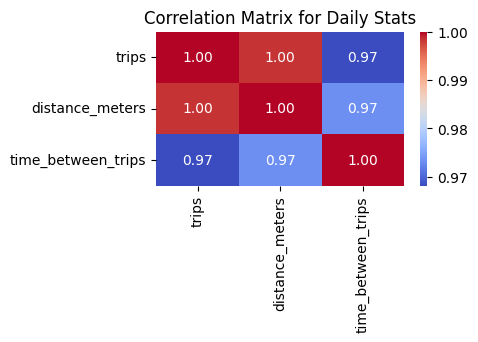

In [40]:
import seaborn as sns

corr = daily_stats.corr(numeric_only=True)
plt.figure(figsize=(4, 2))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Daily Stats')
plt.show()


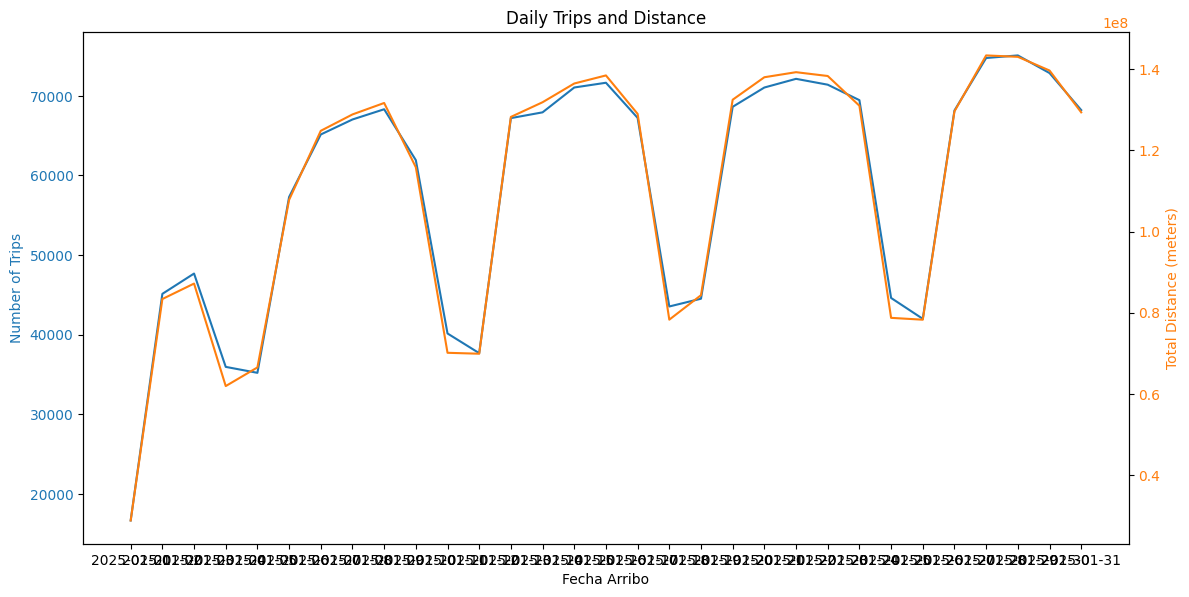

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(daily_stats['fecha_arribo'], daily_stats['trips'], color='tab:blue', label='Trips')
ax1.set_xlabel('Fecha Arribo')
ax1.set_ylabel('Number of Trips', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(daily_stats['fecha_arribo'], daily_stats['distance_meters'], color='tab:orange', label='Distance (meters)')
ax2.set_ylabel('Total Distance (meters)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('Daily Trips and Distance')
plt.show()